In [1]:
import argparse
import sys
sys.path.append('../../gears_misc/')

from gears import PertData, GEARS

dataset = 'norman_umi_go'
data_path = '/dfs/project/perturb-gnn/datasets/data/'
#test_pert_genes = 'CEBPB'
model = 'gears'
device = 2
seed = 1

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from gears.utils import get_GI_genes_idx, get_GI_params, get_mean_control

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def GI_true(combo, adata, mean_df, GI_genes_file='./genes_with_hi_mean.npy', mean_control=None):
    pred = {}
    g1 = combo[0]
    g2 = combo[1]
    comboname = '_'.join(combo)
    
    try:
        pred[g1] = mean_df.loc[g1+'+ctrl']
    except:
        pred[g1] = mean_df.loc['ctrl+'+g1]
        
    try:
        pred[g2] = mean_df.loc[g2+'+ctrl']
    except:
        pred[g2] = mean_df.loc['ctrl+'+g2]
    
    try:
        pred[comboname] = mean_df.loc['+'.join(combo)]
    except:
        pred[comboname] = mean_df.loc['+'.join(combo[::-1])]
    
    if mean_control is None:
        mean_control = get_mean_control(adata).values  
    pred = {p:pred[p]-mean_control for p in pred} 
    
    if GI_genes_file is not None:
    # If focussing on a specific subset of genes for calculating metrics
        GI_genes_idx = get_GI_genes_idx(adata, GI_genes_file)       
    else:
        GI_genes_idx = np.arange(len(adata.var.gene_name.values))

    pred = {p:pred[p][GI_genes_idx] for p in pred}
    
    return get_GI_params(pred, combo)

In [4]:
def load_data(seed, test_pert):
    pert_data = PertData(data_path[:-1], gene_path='/dfs/user/yhr/gears2/Evaluation/data/essential_norman.pkl') # specific saved folder
    pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
    pert_data.prepare_split(split = 'combo_seen2', seed = seed, test_perts = test_pert)
    pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)
    
    adata_df = pert_data.adata.to_df()
    adata_df['condition'] = pert_data.adata.obs['condition']
    mean_df = adata_df.groupby('condition').mean()
    ctrl_mean = mean_df.loc['ctrl']
    
    return pert_data, ctrl_mean, mean_df

def load_model(pert_data, test_pert):
    gears_model = GEARS(pert_data, device = 'cuda:8', 
                weight_bias_track = False, 
                proj_name = 'norman_go', 
                exp_name = 'gears')
    gears_model.load_pretrained('./model_ckpt/GI/norman_umi_go_' + test_pert)
    
    return gears_model
    

In [5]:
all_GI_values = {}

### Iterate over all trained leave-one-out GI models

In [6]:
import pandas as pd
gene2go = pd.read_pickle('/dfs/project/perturb-gnn/datasets/data/gene2go_all_ext.pkl')

In [7]:
#perts_missed = ['RHOXF2BB+ZBTB25', 'LYL1+IER5L', 'RHOXF2BB+SET']

In [8]:
import scanpy as sc
adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/data/norman/perturb_processed.h5ad')

In [9]:
len(glob.glob('/dfs/user/yhr/gears2/Evaluation/model_ckpt/GI/norman_umi_go_*'))

131

In [10]:
for idx, GI_loo_trained_model in enumerate(glob.glob('/dfs/user/yhr/gears2/Evaluation/model_ckpt/GI/norman_umi_go_*')):
    test_pert = GI_loo_trained_model.split('_')[-1]
    
    print(idx)
    if idx==0:
        pert_data, ctrl_mean, mean_df = load_data(seed, test_pert)
    gears_model = load_model(pert_data, test_pert)
    
    all_GI_values[test_pert] = {}
    combo = test_pert.split('+')
    all_GI_values[test_pert]['pred'] = gears_model.GI_predict(combo)
    all_GI_values[test_pert]['true'] = GI_true(combo, gears_model.adata, mean_df=mean_df, 
                                               mean_control=ctrl_mean)
    
    del(gears_model)

0


Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


In [11]:
np.save('./model_ckpt/GI/all_GI_values_seed3', all_GI_values)

### Visualization

In [37]:
all_GI_values = np.load('./model_ckpt/GI/all_GI_values_seed2.npy', allow_pickle=True).item()

In [38]:
metric_dict = {}

for metric in ['mag', 'corr_fit', 'dcor', 'eq_contr']:
    metric_dict[metric] = []
    for item in all_GI_values.values():
        metric_dict[metric].append([item['true'][metric], item['pred'][metric]])

In [39]:
len(metric_dict['mag'])

131

(0.0, 2.25)

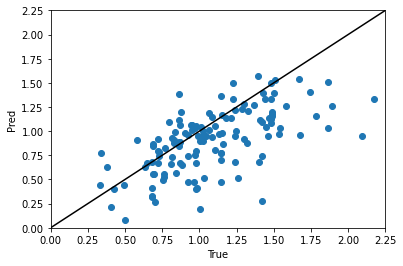

In [40]:
plt.scatter(np.array(metric_dict['mag'])[:,0], np.array(metric_dict['mag'])[:,1])
plt.plot([0,2.25],[0,2.25], color='k')
plt.xlabel('True')
plt.ylabel('Pred')

plt.ylim([0,2.25])
plt.xlim([0,2.25])

In [41]:
pearsonr(np.array(metric_dict['mag'])[:,0], np.array(metric_dict['mag'])[:,1])[0]**2

0.383242147530967

(0.0, 1.0)

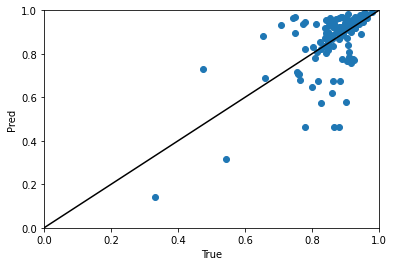

In [42]:
plt.scatter(np.array(metric_dict['corr_fit'])[:,0], np.array(metric_dict['corr_fit'])[:,1])
plt.plot([0,1.0],[0,1.0], color='k')
plt.xlabel('True')
plt.ylabel('Pred')

plt.ylim([0,1.0])
plt.xlim([0,1.0])

In [43]:
pearsonr(np.array(metric_dict['corr_fit'])[:,0], np.array(metric_dict['corr_fit'])[:,1])[0]**2

0.3629488966421176

In [44]:
pearsonr(np.array(metric_dict['eq_contr'])[:,0], np.array(metric_dict['eq_contr'])[:,1])[0]**2

0.5296816564727487

(0.0, 1.0)

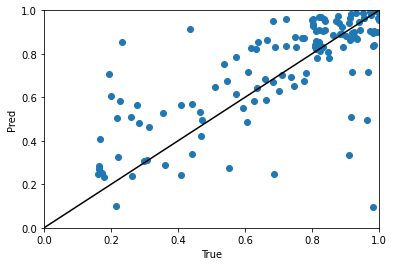

In [45]:
plt.scatter(np.array(metric_dict['eq_contr'])[:,0], np.array(metric_dict['eq_contr'])[:,1])
plt.plot([0,1.0],[0,1.0], color='k')
plt.xlabel('True')
plt.ylabel('Pred')

plt.ylim([0,1.0])
plt.xlim([0,1.0])

(0.0, 1.0)

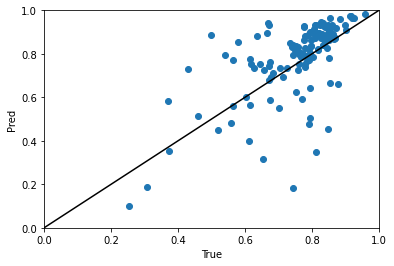

In [46]:
plt.scatter(np.array(metric_dict['dcor'])[:,0], np.array(metric_dict['dcor'])[:,1])
plt.plot([0,1.0],[0,1.0], color='k')
plt.xlabel('True')
plt.ylabel('Pred')

plt.ylim([0,1.0])
plt.xlim([0,1.0])

In [47]:
pearsonr(np.array(metric_dict['dcor'])[:,0], np.array(metric_dict['dcor'])[:,1])[0]**2

0.4085177296096987